## IBM Q X 15-qubit device:
### Scalable characterization of all local-averaged Pauli error rates

© Robin Harper 2016-2020

**NOTE** this workbook requires Julia and the module Juqst.

Juqst can be obtained at [https://github.com/rharper2/Juqst.jl](https://github.com/rharper2/Juqst.jl) and that repo contains all the software needed an more detailed descriptions (in the docs/examples/quantumNoise folder) of the analysis contained here.

I have just reproduced one of the workbooks (altered for 15 qubits) to show how the data gathered by the workbooks in this repo might be analysed.

Best viewed with the nbextensions, Collapsible Headings enabled.

<span style="color:blue">
The purpose of this notebook is to analyze data from the IBM 15-qubit quantum device (Melbourne) taken using the scalable noise reconstruction protocol for estimating averaged Pauli error rates. 
</span>    
    
In this worksheet we won't produce error bars. To see how we use bootstrapping to do this, checkout the SingleQubitProtocol worksheet.

-----


<span style="color:red">
Do not analyse things without error bars. It is too easy to see non-existent correlations without error bars! Go to the Juqst.jl to see how to create the error bars. This is a simplified example only</span>
   


© Robin Harper 2020

# Load in the software we are using


1. We use a few standard Julia packages, which will need to be added if you don't have them.

 - LsqFit
 - Hadamard
 - PyPlot
 - ProgressMeter

2. Define a couple of convenience functions.


In [1]:
using LsqFit
using Hadamard
using PyPlot
using ProgressMeter
# Instructions for Juqst at https://github.com/rharper2/Juqst.jl
using Juqst
# convenience (type /otimes<tab>)
⊗ = kron

kron (generic function with 34 methods)

In [2]:
# A lot of the drawing stuff is particular to the IBM 14 qubit machine
# and is in a seperate file
include("marginalDrawing.jl")

covhinton

In [3]:
# The fitting model, for use with LsqFit.
modelF(x, p) = p[1]*(p[2].^x)

modelF (generic function with 1 method)

# Load in the single qubit twirl data

 - read in the files
 - transform and fit, extracting the fit parameter into params
 
 We have 
 - singleParams - which will equal the Clifford eigenvalues
 - singlePs - which represents the global SPAM free probabilities (possibly with small negative values)
 - singlePps - which reprepesnts singlePs, projected onto the nearest probability simplex.




In [4]:
# Read in the raw results stored on a per sequence length
# Binary valued so first entry = 0000000000000000
# Then a 1 on qubit 0 is the second entry i.e. 0000000000000001
# all the way to a 1 on all qubits 111111111111111111111111
using DelimitedFiles
# The re-run of single qubit had a longer tail.
singleLengths=[1,5,10,15,20,30,45,60,75,90,110]
fullMatrixS = readdlm("./data/results15_17June2020.csv",',',Int64);
fullMatrixS

11×32768 Array{Int64,2}:
 252018  9048  23015  924  9581  372  …  0  0  0  0  0  0  0  0  0  0  0  0
 210502  7485  21194  812  9647  308     0  0  0  0  0  0  0  0  0  0  0  0
 171183  6491  18728  802  9228  337     0  0  0  0  0  0  0  0  0  0  0  0
 141534  5959  16801  811  8189  370     0  0  0  0  0  0  0  0  0  0  0  0
 115142  5261  14940  818  8267  362     0  0  0  0  0  0  0  0  0  0  0  0
  79313  4050  11554  763  6811  377  …  0  0  0  0  0  0  0  0  0  0  0  0
  48993  3016   8580  666  5682  371     0  0  0  0  0  0  0  0  0  0  0  0
  32433  2446   6625  593  4545  345     0  0  0  0  0  0  0  0  0  0  0  0
  20912  1677   5000  435  3495  293     0  0  0  0  0  0  0  0  0  0  0  0
  15085  1423   3987  490  3020  262     0  0  0  0  0  0  0  0  0  0  0  0
   9739  1049   3038  363  2348  262  …  0  0  0  0  0  0  0  0  0  0  0  0

In [5]:
# Approximately 1 million shots (1000*1024)
sum(fullMatrixS[2,:])

864256

In [6]:
# Split it up into different arrays all the runs of a particular length, altered to a probability.
splitMatrixS=[fullMatrixS[i,:]/sum(fullMatrixS[i,:]) for i in 1:length(singleLengths)];

In [7]:
params, dataL  = fitTheFidelities(singleLengths,splitMatrixS);
singleParams = params;

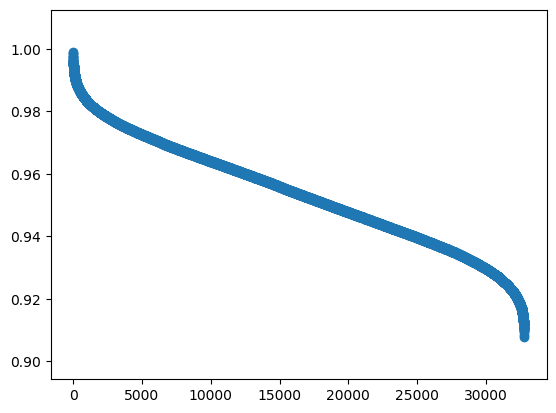

PyObject <matplotlib.collections.PathCollection object at 0x7f98e8b3e110>

In [8]:
# We can plot all the fidelities...
scatter(1:length(singleParams),reverse(sort(map(x->x[2],singleParams))))

In [9]:
## The global probability vector is now the hadamard transform of the parameters
## And we project it down onto an actual probability simplex.

singlePs =  fwht_natural(vcat([1],map(x->x[2],singleParams)))
singlePps = projectSimplex(singlePs);

# Mutual Information plots


Used in Figure 2

- Generates the Mutual Information between each of the qubits.
- Then does this again for each of the boostrapped versions.

Draws them using a Hinton Plot, set out as per IBM layout

In [10]:
mutualPsSingle = [[mutualInformation(q,i,singlePps) for q in 1:15] for i in 1:15];


### We are now going to draw some things. 

A lot of the visualisation is quite particular to the layout of the 14 qubit machine.


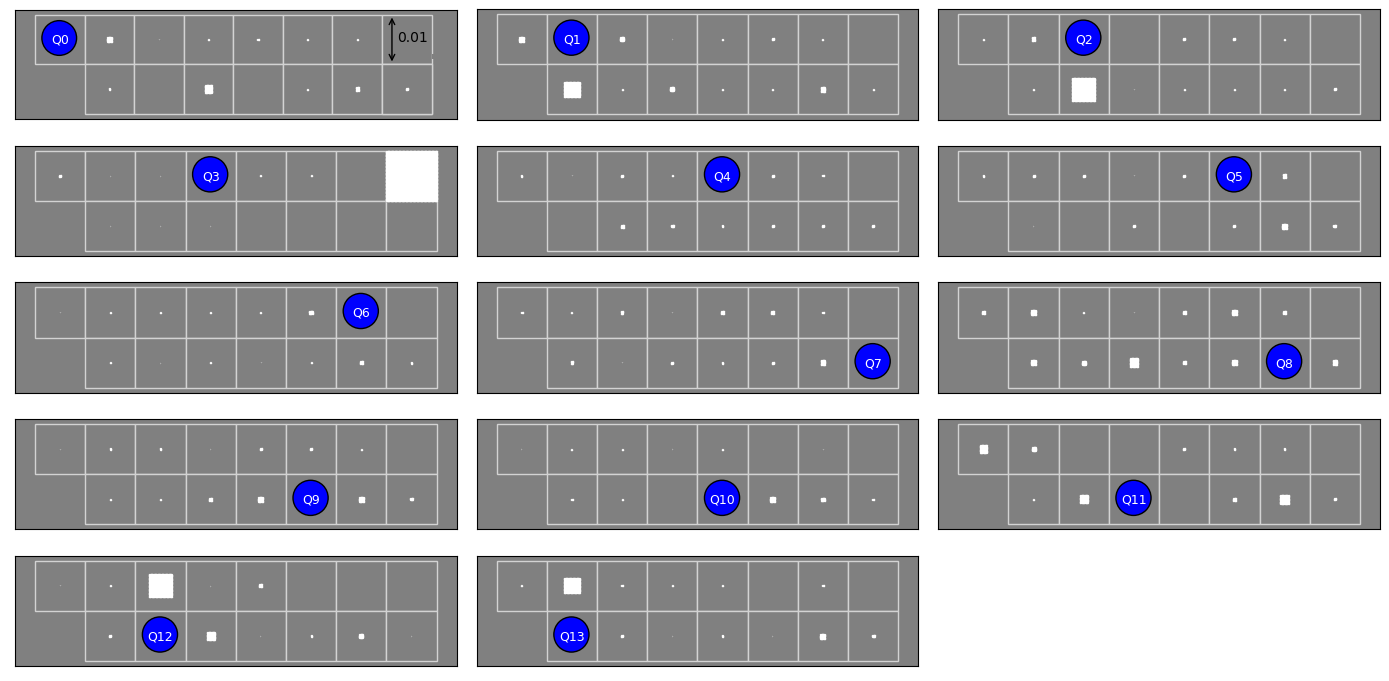

In [11]:
## Draw the hinton diagrams showing the mutual information between qubits
## translate_15Q_Locations just puts the qubits in the correct place for the Melbourne device.

fig = figure("Qubits Single Sigma",figsize=(14,7))
for i =1:14
    subplot(5,3,i)
    hinton(translate_15Q_Location(mutualPsSingle[i]',1),
        0.01,gca(),
        highlightNegative=true,fontsize=9,qubitPairs=[],addScale=i==1)
end
plt.tight_layout()


# Correlation Matrices



Used in Figure 2.

- corrmatSingle: the 14x14 correlation matrix using the projected global probability
- corrmatsSingle: the 14x14 correlation matrices for each of the bootstrapped probabilities.

In [12]:
corrmatSingle = correlationMatrix(singlePps);


In [13]:
size(corrmatSingle)

(15, 15)

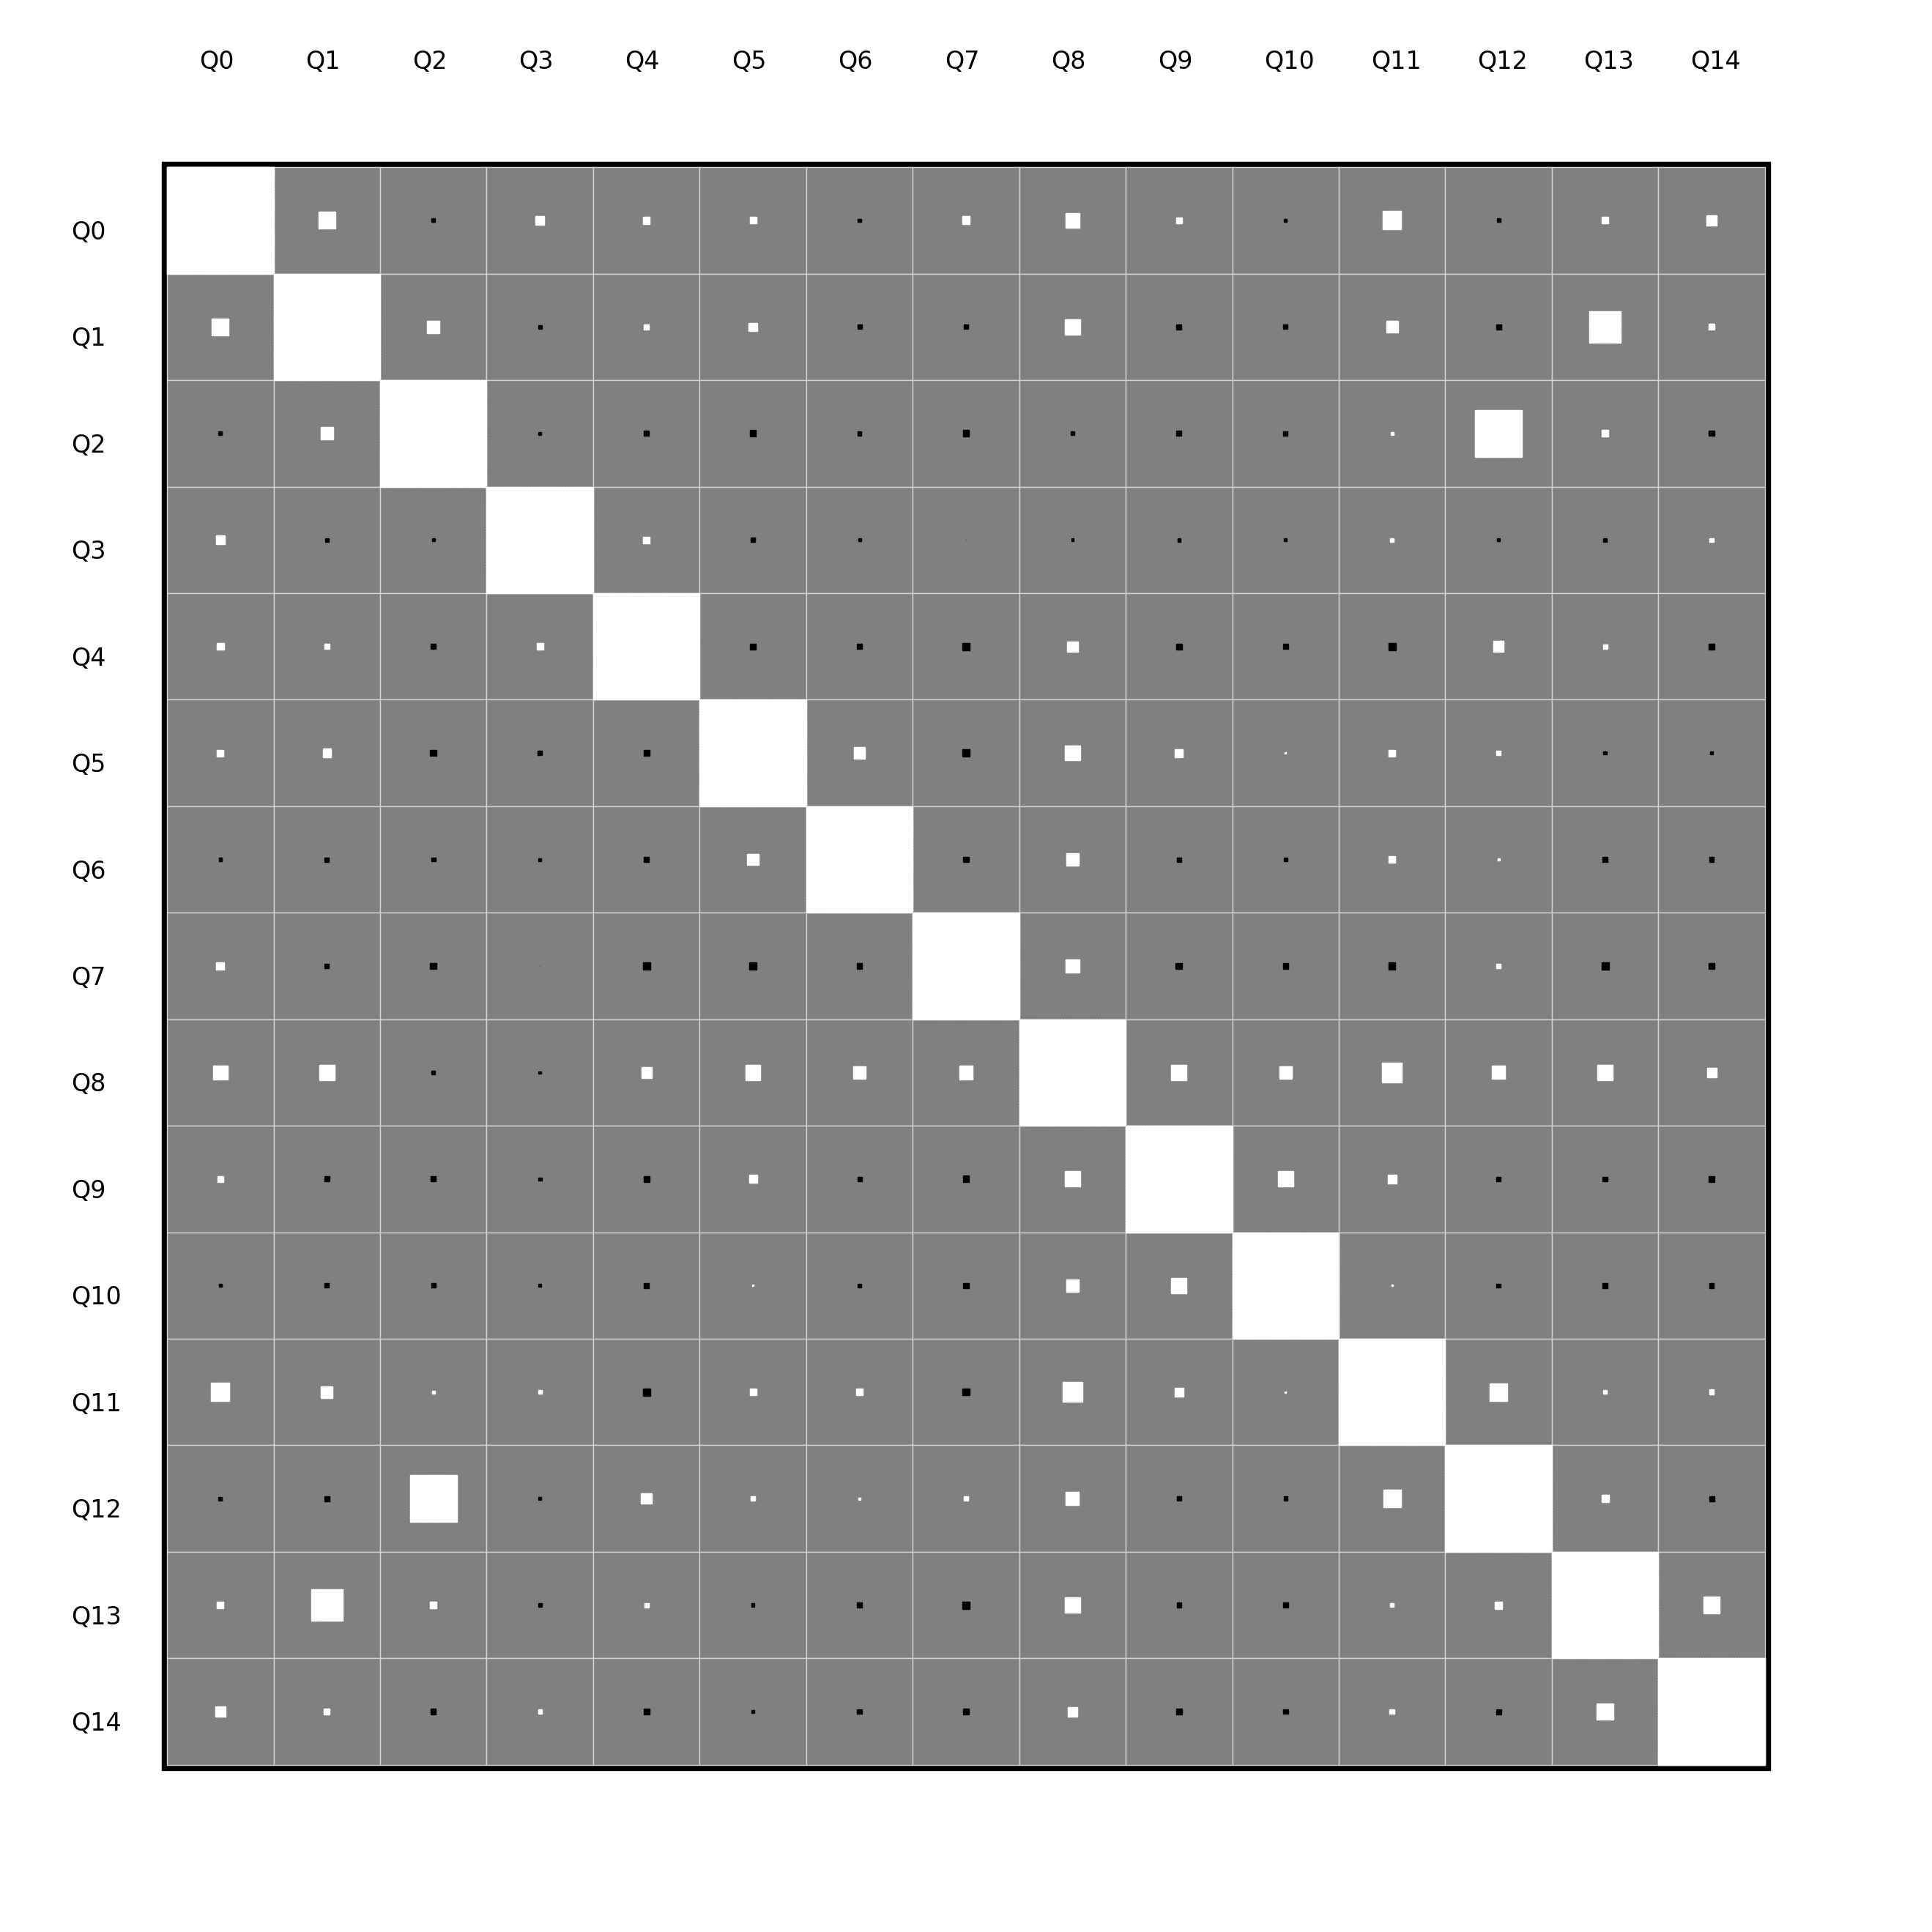

In [14]:
## This is a conventional hinton plot (area equals value, white = +ve, black = -ve)
# Large figure size gives us a crisp plot

#### WE WOULD NEED ERROR BARS TO SEE IF THE EXTRA CORRELATIONS ON QUBIT 8 ARE "REAL"
# It may be that we need more data to nail that one down.

fig = figure("Slightly larger",figsize=(34,34))

covhinton(corrmatSingle,1,gca(),
    addScale=false,addAxis=true,adjust=0.8,addOneAxis=true,showQubits=false,fontsize=24,stagger=false)



# Generate the GRF using global probabilities



This is based on the following 'ansatz'

![grf](./grf.png)

Where qubits have been renumbered to account for Julia prefering 1-indexing.

Used: 
- to construct JSD numbers in paper.
- Figure 2
- Figure 5 (supplement)

Creates:
- ϕ the joint probabilities for the Gibbs field.
- reconstructed, the reconstructed global probability distrubtion using ϕ
- corrmatSingleGibbs: The correlation matrix using the reconstructed probability distribution
- corrmatsSingleGibbs: The correlation matrix using the reconstructip p.d. for bootstrap data.



## Calculate the JSD for the ansatz

In [15]:
# This is our 'ansatz' based on the resonators of the IBM
# This is the 'simplest' way to use the software, but it requires the constraints in a particular way
# Here we look at the overlap so [[1,2,14],[2,14]] - would mean p(1,2|2,14)p(2,14) etc.

constraints = [[1,15,2,14],[2,14,13,3],[13,3,4,12],[4,12,5,11],[5,11,6,10],[6,10,7,9],[7,9,8]]

7-element Array{Array{Int64,1},1}:
 [1, 15, 2, 14]
 [2, 14, 13, 3]
 [13, 3, 4, 12]
 [4, 12, 5, 11]
 [5, 11, 6, 10]
 [6, 10, 7, 9]
 [7, 9, 8]

### We can look at the Relative Entropy between our $\tilde{\,p}_1$ and the reconstructed p

$D_{KL}(P||Q) = \sum\limits_{j}p_j\log\frac{p_j}{q_j}$

But *note* this is not defined if $q_j$ is zero when $p_j$ is non-zero, and it is not symmetric.

Instead use... 

### Jensen Shannon divergence 

Jensen Shannon divergence is symmetric, always valid and if you take the square root (Jensen Shannon Distance) it is a metric.

$\text{JSD}(P||Q) = \frac{1}{2}D(P||M) + \frac{1}{2}D(Q||M), M = \frac{1}{2}(P+Q)$

In [16]:
# A different (more general) way of expressing the constraints is, lists of conditionals
# So here we write out p(1|2,14)p(2,14|13,3)p(13,3|4,12)p(4,12|5,11)p(6,10|7,9)p(7,9,8)
# as

generalisedConstraints =[
                            [[1,15],[2,14]],
                            [[2,14],[13,3]],
                            [[13,3],[4,12]],
                            [[4,12],[5,11]],
                            [[5,11],[6,10]],
                            [[6,10],[7,9]],
                            [[7,9,8],[]]]

# Which is the same as the one above.

7-element Array{Array{Array{Any,1},1},1}:
 [[1, 15], [2, 14]]
 [[2, 14], [13, 3]]
 [[13, 3], [4, 12]]
 [[4, 12], [5, 11]]
 [[5, 11], [6, 10]]
 [[6, 10], [7, 9]]
 [[7, 9, 8], []]

In [17]:
ϕold = gibbsRandomField(singlePps,constraints) 
reconstructed_old = [getGrainedP(ϕold,tomatch,[vcat(x[1],x[2]) for x in generalisedConstraints]) for tomatch =0:(2^15-1)]
sqrt(JSD(singlePps,reconstructed_old))

0.024165880147539058

In [18]:
# Then we can fill in the joint probabilities:
ϕ=gibbsRandomField(singlePps,generalisedConstraints) 
# Reconstruct the entire probability distribution using our markov field.
reconstructed = [getGrainedP(ϕ,tomatch,[vcat(x[1],x[2]) for x in generalisedConstraints]) for tomatch =0:(2^15-1)]
# And check we get the same JSD as with the earlier version
sqrt(JSD(singlePps,reconstructed))

0.024165880147539058

## Generate GRF correlations matrix

In [19]:


corrmatSingleGibbs = correlationMatrix(reconstructed);


## Plot the GRF Correlation Matrix.

- Note its pretty good but we are missing the longer correlations on qubit 8

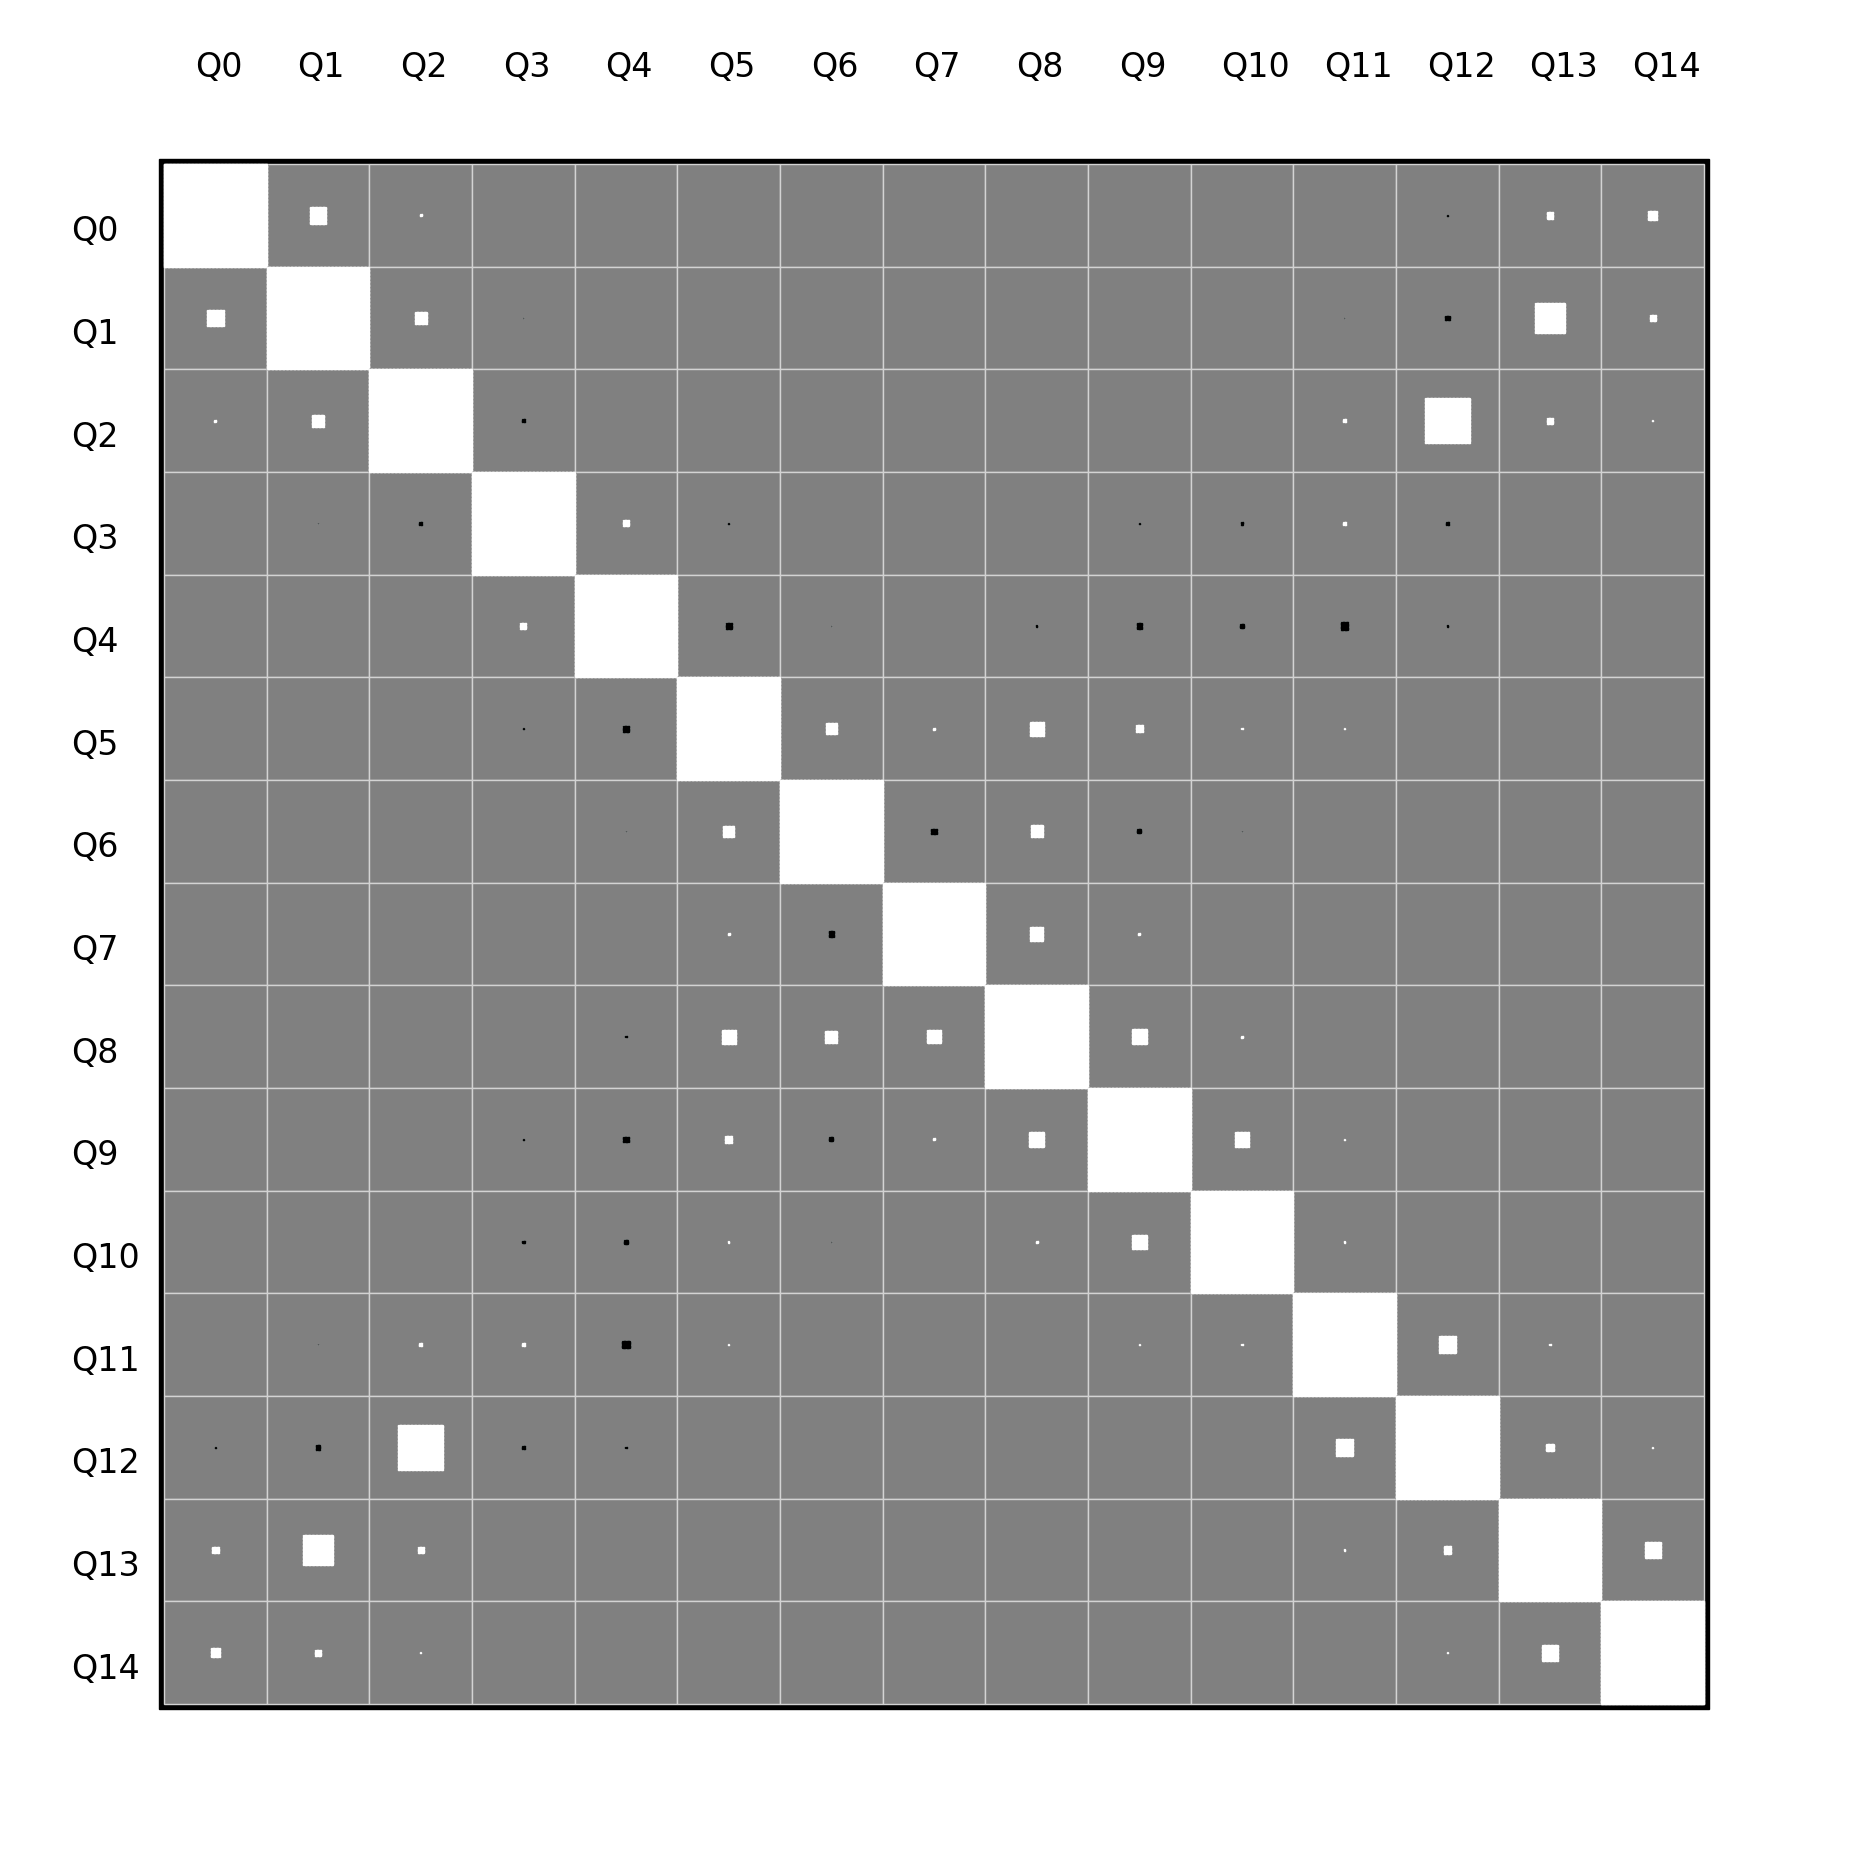

In [20]:
fig = figure("Slightly larger",figsize=(24,24))

fig = figure("Slightly larger",figsize=(12,12))

covhinton(corrmatSingleGibbs,1,gca(),
    addScale=false,addAxis=true,adjust=0.8,addOneAxis=true,showQubits=false,fontsize=24,stagger=false,ind=collect(0:14))


## Reproduce the combined Plot shown in Figure 2

In [21]:
# To fully recreate the correlation matrix in Figure 2, we need to combine our previous charts.

### AGAIN NOTE - this is the simplified version (without error bars)

corrmatCombined = copy(corrmatSingle)
for j = 2:14
    for i = 1:j-1
        corrmatCombined[i,j] = corrmatSingleGibbs[i,j]
    end
end

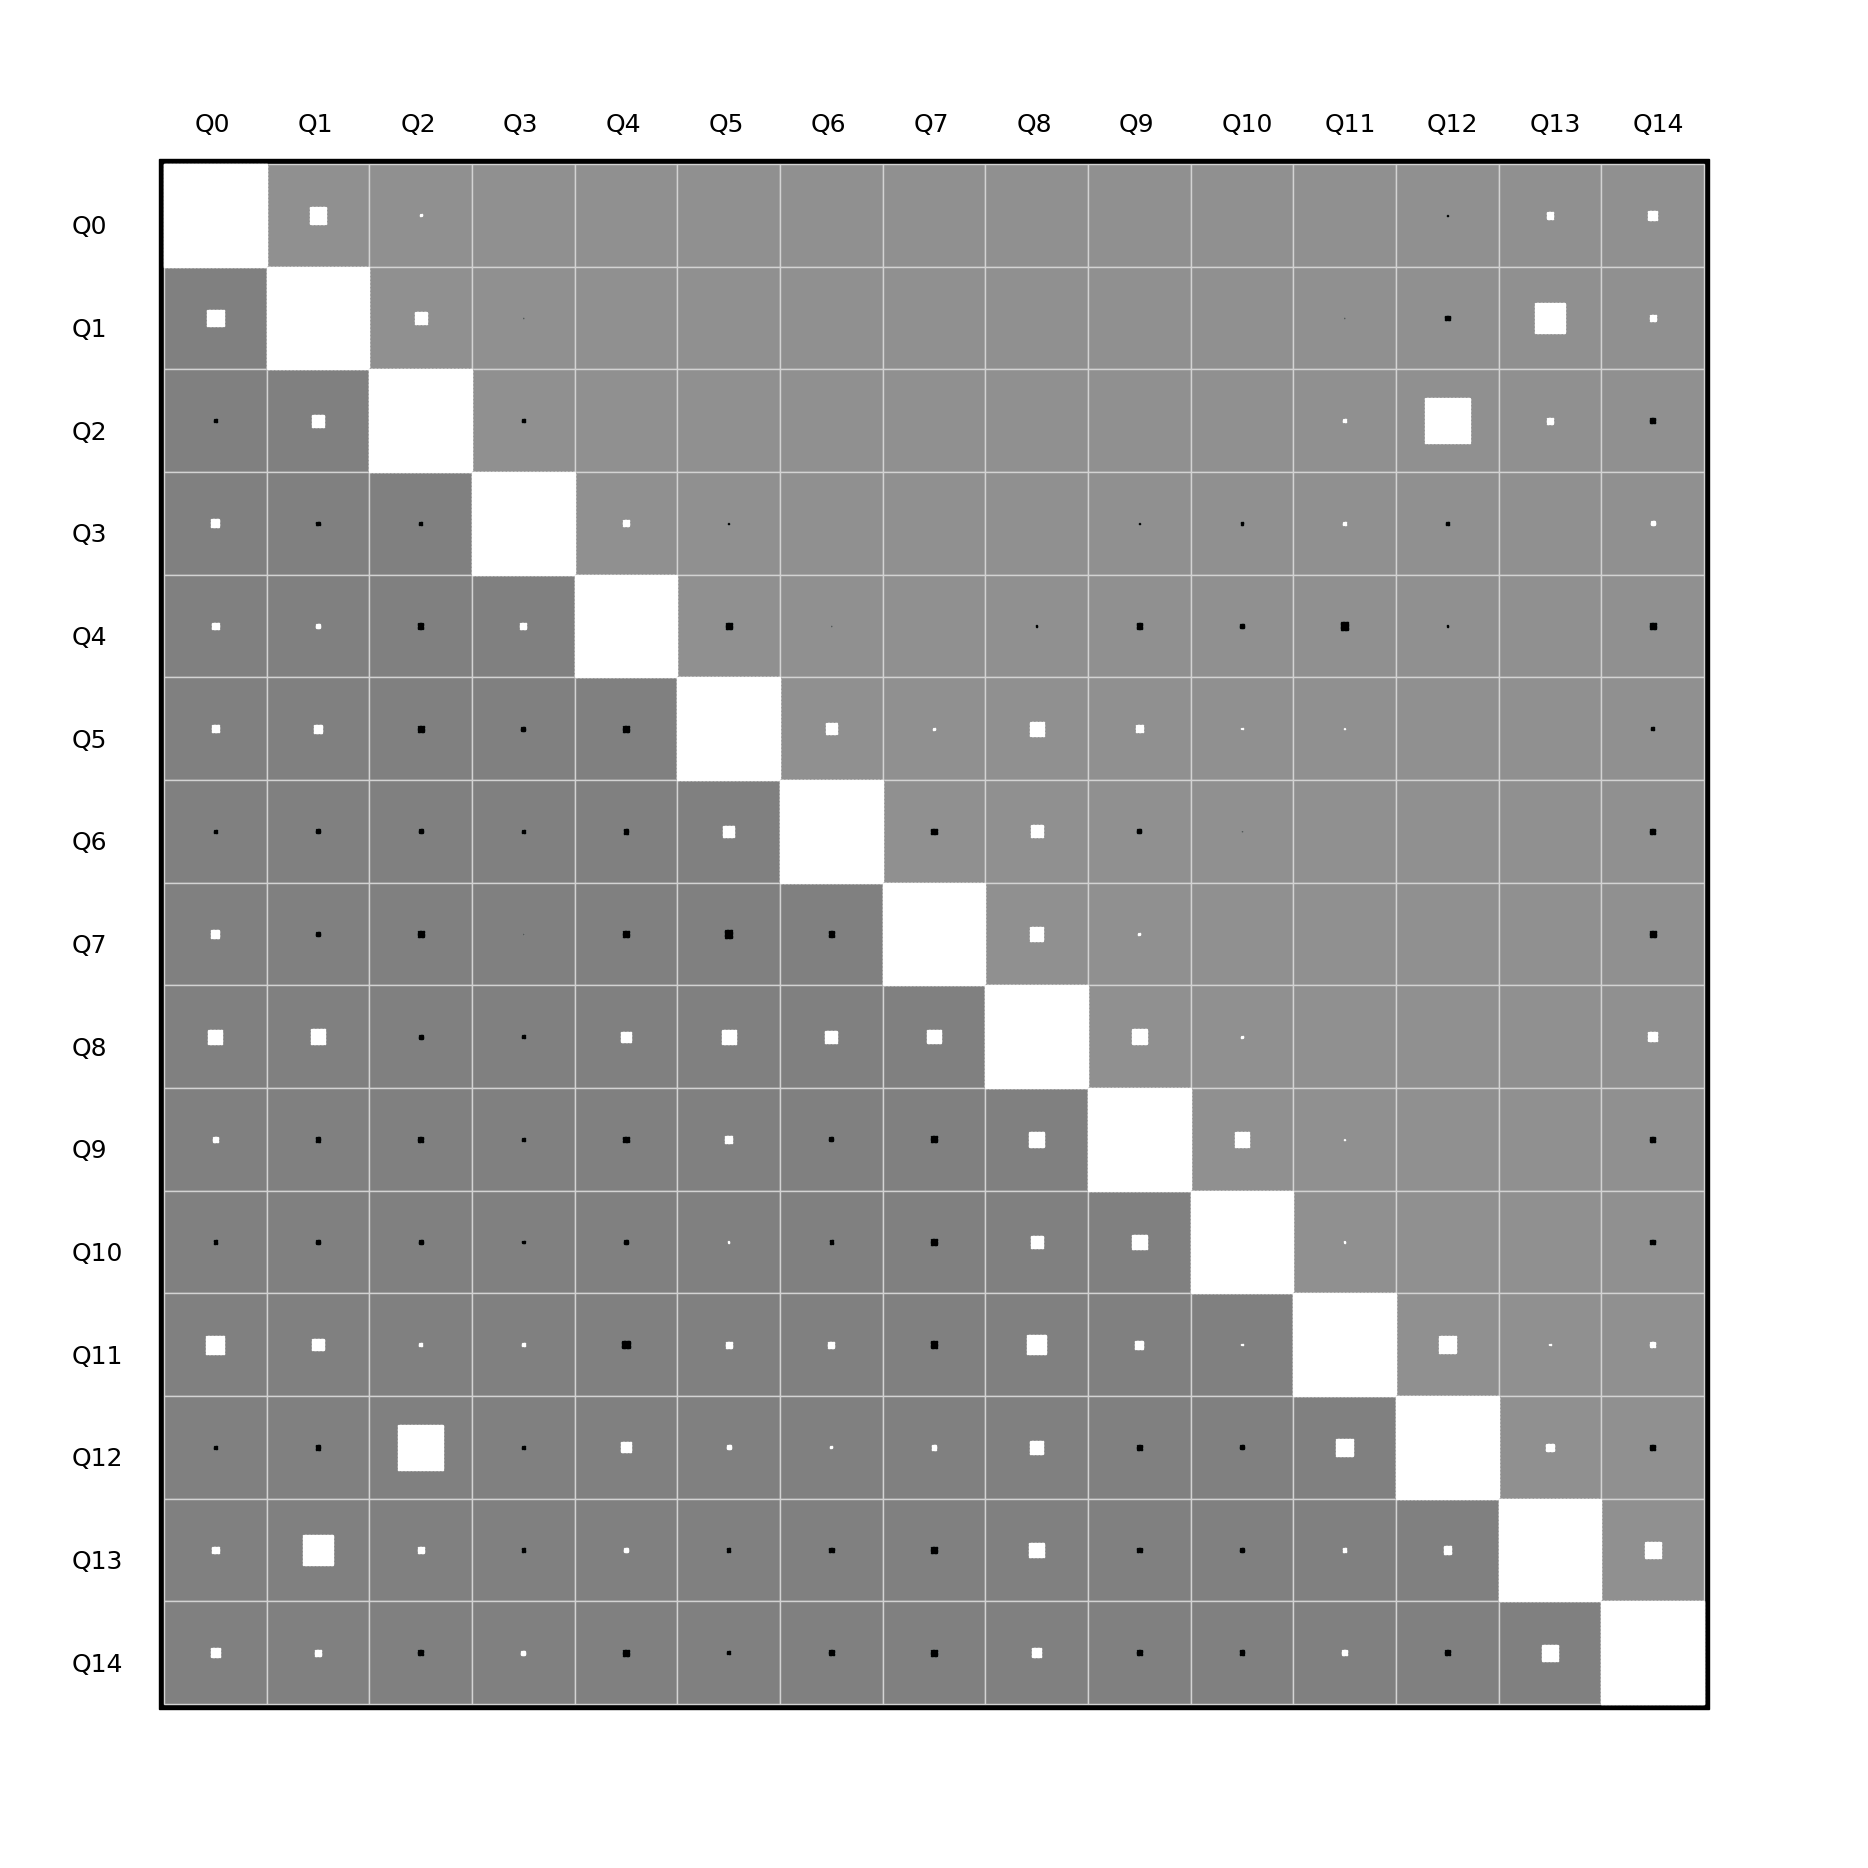

In [22]:
fig = figure("Slightly larger",figsize=(24,24))
covhinton(corrmatCombined,1,gca(),
    addScale=false,
    addAxis=true,
    adjust=0.8,
    voffset=0.6,
    ind=collect(0:14),
    addOneAxis=true,
    showQubits=false,
    fontsize=18,
    stagger=false,
    altColor="#909090")



### Seeing how good the "fidelities" are

Note these are decay rates (typcially called the 'p' parameter). For a single qubit it is related to fidelities as

$\mathcal{F} = \frac{p+1}{2}$, and more generally $\mathcal{F} = \frac{(d-1)p+1}{d}$

In [23]:

for i = 1:15
    print("$i -> $(singleParams[2^(i-1)][2])\n")
end

1 -> 0.9985194188350979
2 -> 0.995492369433089
3 -> 0.9956824163903969
4 -> 0.9990299608069885
5 -> 0.9939774153644014
6 -> 0.9888922006041952
7 -> 0.9974381201404456
8 -> 0.9898954093694455
9 -> 0.9982320200342412
10 -> 0.9953238232588043
11 -> 0.9974291752919313
12 -> 0.973005548747547
13 -> 0.9960761938099272
14 -> 0.9927134854991602
15 -> 0.9940726955206387


# Sanity check

We might wonder about qubit 12 (well 11 on the device) was the data really showing single qubit fidelities that poor?

We can marginalise our data - so if we marginalise that qubit we effectively get the 'simultaneous' RB data for that qubit - i.e. the survival probability for the qubit e.g.

In [24]:
# We might wonder about qubit 12, was the data really showing fidelities that poor?
[marginalise([12],s) for s in splitMatrixS]

11-element Array{Array{Float64,2},1}:
 [0.9435780602043885 0.05642193979561599]
 [0.8950484578643426 0.10495154213566325]
 [0.8463013273844859 0.15369867261552078]
 [0.8039897900622103 0.1960102099377952]
 [0.7635688962529688 0.2364311037470371]
 [0.6973986874259549 0.30260131257405637]
 [0.6318914765995315 0.3681085234004784]
 [0.5906351821682524 0.40936481783175743]
 [0.5471006275918288 0.45289937240817973]
 [0.5426146882405253 0.457385311759482]
 [0.5186136977932493 0.48138630220675604]

So let us extract that and print...

In [25]:
q12Survival = [marginalise([12],s)[1] for s in splitMatrixS]

11-element Array{Float64,1}:
 0.9435780602043885
 0.8950484578643426
 0.8463013273844859
 0.8039897900622103
 0.7635688962529688
 0.6973986874259549
 0.6318914765995315
 0.5906351821682524
 0.5471006275918288
 0.5426146882405253
 0.5186136977932493

In [26]:
# We want a cut-off at approximately:
cutoff = (0.94-0.5)*17/64+0.5
# So take the first 8 data points.

0.616875

In [27]:
modelRB(x, p) = p[1]*(p[2].^x).+0.5
fit = curve_fit(modelRB,singleLengths[1:8],q12Survival[1:8],[0.8,0.8],upper=[1.0,1.0],lower=[0.01,0.01])
print(fit.param)


[0.4550326476190028, 0.9730055487538315]

In [28]:
[modelRB(x,fit.param) for x in 1:100]

100-element Array{Float64,1}:
 0.9427492909974367
 0.9307975168473307
 0.919168374281825
 0.9078531540383386
 0.8968433819560546
 0.8861308126294771
 0.8757074232333073
 0.8655654075140122
 0.8556971699435896
 0.8460953200311472
 0.8367526667880393
 0.8276622133424123
 0.8188171516991289
 ⋮
 0.5398387555417955
 0.5387633301976145
 0.5377169353704558
 0.5366987873974431
 0.5357081237702493
 0.5347442025640412
 0.5338063018818392
 0.5328937193138766
 0.532005771411553
 0.5311417931755879
 0.5303011375579912
 0.5294831749774785

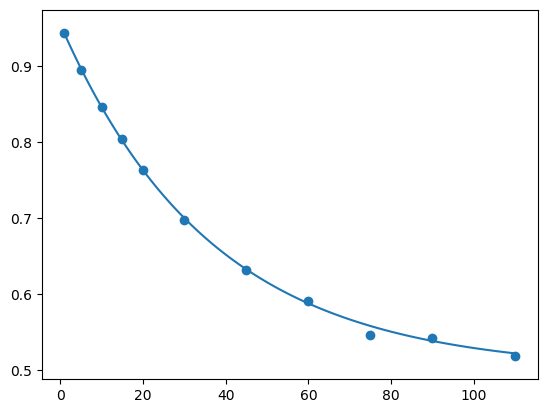

0.973005548747547

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f991b88e710>

In [29]:
print(singleParams[2^(12-1)][2])
scatter(singleLengths,q12Survival)
plot(1:110,[modelRB(x,fit.param) for x in 1:110])

## Looks like it really did have that single qubit 'decay' parameter.

(Just for the sake of compelteness that means its reported fidelity will be)

In [30]:
Fidelityqb = (fit.param[2]+1)/2

0.9865027743769157

Which is quite different from the spec sheet!

# Reconstruct the GRF by maginalising at the data results level


We take shortcut by omitting an easily writeable (if tedious) step. 

Recall we have our raw observation matrices for each of the RB lengths, stored in $2^{14}$ vectors, because this is quite a well behaved machine they are sparse. However if we really had $n$=50 qubits, then we couldn't store these vectors. We don't need to store it, read on:

The algorithm I'm going to call works as follows:

It uses the constraints for the Gibbs Random Field, to work out that what I need is, say, the joint probability distribution of qubits 1,2,3 and 4. To get them it marginalises the raw data probabilities (so the $2^4$ set of numbers that represent the measurement outcome probabilities for these qubits, irrespective of the outcomes of the others). Now I lazily just pass in the $2^{14}$ vector and then call marginalise on it.

If I couldn't do that (n=50), I would have to read in each of the measurement strings, extract the relevant qubits from each bitstring and then create the $2^4$ set of probabilities. That is an easy (if fidly) programming exercise that just requires you storing a large number of 50 bit bitstring (for n=50). To make it as efficient as possible might be fun, but I'm not going to do it until I need to.

So assuming we marginalised our input data we then then work out the joint probabilities we want.

It goes like this:

1) marginalised the input data. 
2) transform with Hadamard.
3) fit, extract the fit parameter.
4) transform back and project (just like before) 

except we are now dealing with really small probabilitiy vectors (2^3, 2^4 etc). The actual size of the probability vectors will depend on the bounded degree of the GRF in question.

This allows us to fill in the values of our gibbs field approximation. And efficiently we are done.

I'll show the few lines of code needed.

The essence of this is to realise that the hadamard **and fitting procedure** commute with marginalisation. This is not immediately obvious, but it means we get **exactly** the same marginalised vector at the end. The only thing that doesn't commute is the projection onto a probabilitiy simplex. That is future work.

Hopefully below explains what I mean here and what we are about to do.

<img src="./hadamard.gif/">

## Reconstruct from marginalising data

- Checks JSD

In [31]:
gibbsϕ2 = marginaliseFromRawData(splitMatrixS,constraints,singleLengths)

7-element Array{Array{Float64,1},1}:
 [0.996417945129683, 0.0006684994083297497, 0.002899838705343306, 1.371675664403491e-5, 0.9722005742804758, 0.02619459951570868, 0.0016048262038154194, 0.0, 0.9784646973037431, 0.0014044324921778392, 0.020130870204078995, 0.0, 0.9871612864344463, 0.01259784998929452, 0.0, 0.00024086357625923194]
 [0.9944857729172921, 0.0019047180349314053, 0.0032988967196494424, 0.00031061232812710496, 0.9755241280087624, 0.004319097514772411, 0.02015677447646506, 0.0, 0.9655997567163096, 0.024685938116062914, 0.009714305167627429, 0.0, 1.0, 0.0, 0.0, 0.0]
 [0.9963894297409135, 0.0014519784204757124, 0.001741666113875903, 0.00041692572473485526, 0.9930682686959525, 0.0, 0.006931731304047436, 0.0, 0.9872268403341945, 0.009928925259415385, 0.002844234406390028, 0.0, 0.17135428443418754, 0.3117568785506245, 0.26409182525529307, 0.2527970117598949]
 [0.9858633723090853, 0.0004409641417956641, 0.013695663549119044, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [32]:
# For the sake of display!
for i in gibbsϕ2
    display(i)
end

16-element Array{Float64,1}:
 0.996417945129683
 0.0006684994083297497
 0.002899838705343306
 1.371675664403491e-5
 0.9722005742804758
 0.02619459951570868
 0.0016048262038154194
 0.0
 0.9784646973037431
 0.0014044324921778392
 0.020130870204078995
 0.0
 0.9871612864344463
 0.01259784998929452
 0.0
 0.00024086357625923194

16-element Array{Float64,1}:
 0.9944857729172921
 0.0019047180349314053
 0.0032988967196494424
 0.00031061232812710496
 0.9755241280087624
 0.004319097514772411
 0.02015677447646506
 0.0
 0.9655997567163096
 0.024685938116062914
 0.009714305167627429
 0.0
 1.0
 0.0
 0.0
 0.0

16-element Array{Float64,1}:
 0.9963894297409135
 0.0014519784204757124
 0.001741666113875903
 0.00041692572473485526
 0.9930682686959525
 0.0
 0.006931731304047436
 0.0
 0.9872268403341945
 0.009928925259415385
 0.002844234406390028
 0.0
 0.17135428443418754
 0.3117568785506245
 0.26409182525529307
 0.2527970117598949

16-element Array{Float64,1}:
 0.9858633723090853
 0.0004409641417956641
 0.013695663549119044
 0.0
 1.0
 0.0
 0.0
 0.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

16-element Array{Float64,1}:
 0.9956720651740346
 0.0031128127729784364
 0.001215122052987007
 0.0
 1.0
 0.0
 0.0
 0.0
 0.9837806786105882
 0.0
 0.01621932138941176
 0.0
 0.0
 0.0
 0.0
 0.0

16-element Array{Float64,1}:
 0.9921432877518536
 0.005519591918706658
 0.002337120329439743
 0.0
 0.9579028235994158
 0.03692193359863332
 0.0051752428019506596
 0.0
 0.9853555394199605
 0.0006614167195684804
 0.013983043860471113
 0.0
 0.5490032767031254
 0.0
 0.0
 0.45099672329687457

8-element Array{Float64,1}:
 0.9927462140234269
 0.0012869178335856684
 0.0008768970113706808
 8.152640720818228e-6
 0.0050818184908960175
 0.0
 0.0
 0.0

In [33]:
# Lets check this out (because we can) blow it up to the full probability distribution
reconstructedPps2 = [getGrainedP(gibbsϕ2,tomatch,constraints) for tomatch=0:(2^15-1)]
print("Should sum to 1: we get:",sum(reconstructedPps2))

Should sum to 1: we get:0.999996323185749

In [34]:
# This is what we had with the 'full' GRF reconstruction
sqrt(JSD(singlePps,reconstructed))

0.024165880147539058

In [35]:
# This is what we had with the 'efficient' GRF construciton
sqrt(JSD(singlePps,reconstructedPps2))

0.024526560261947213

## Create Correlation matrices

In [36]:
# Then the GRF from the marginalised observations
corrmatSingleGibbsM = correlationMatrix(reconstructedPps2);



In [37]:
# Moosh them together so one is in the top right and the other in the bottom left
corrmatCombined = copy(corrmatSingleGibbs)
for j = 2:14
    for i = 1:j-1
        corrmatCombined[i,j] = corrmatSingleGibbsM[i,j]
    end
end
    

## Generate a figure, which should have been in the supplement of our paper, but...

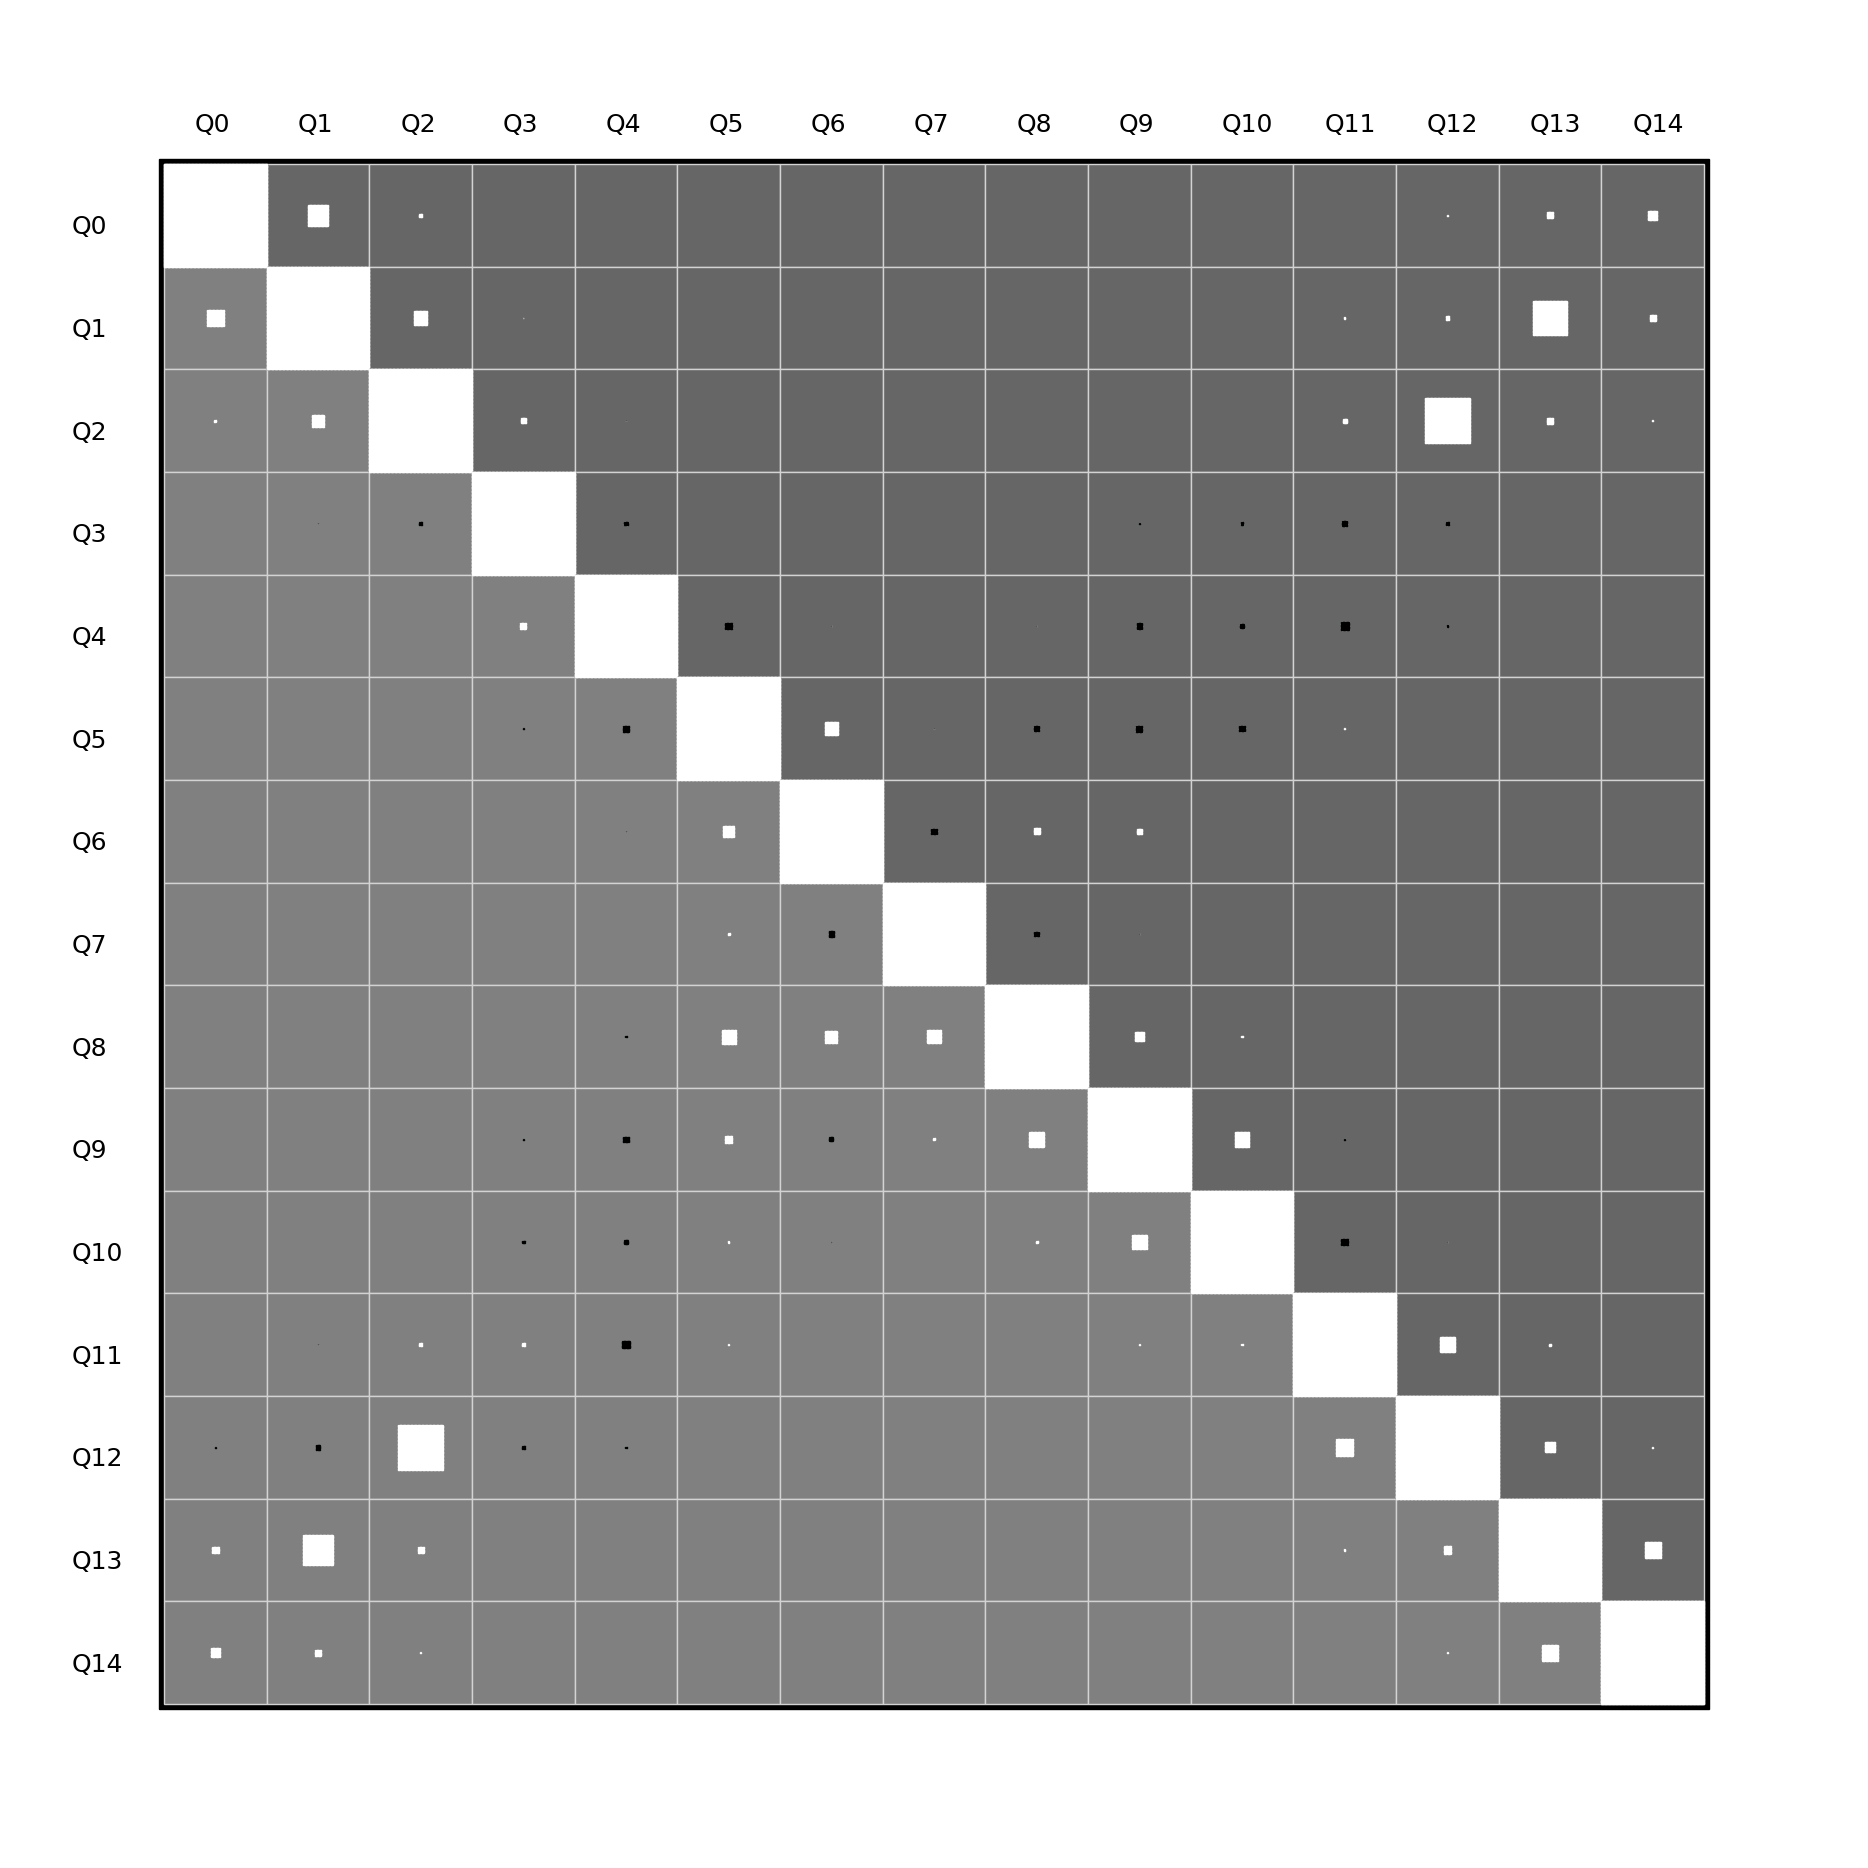

In [38]:
fig = figure("Slightly larger",figsize=(24,24))
covhinton(corrmatCombined,1,gca(),
    addScale=false,
    addAxis=true,
    adjust=0.8,
    voffset=0.6,
    addOneAxis=true,
    showQubits=false,
    fontsize=18,
    stagger=false,
    altColor="#666666",
    ind=collect(0:14))

